In [1]:
import time
import random
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.widgets import Cursor
from PIL import Image,ImageDraw
import hashlib
from yolo_opencv import detect_object
import pandas as pd
from ultralytics import YOLO
import numpy as np

import pywt
from nistrng import pack_sequence, unpack_sequence
from typing import List
import itertools
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.signal import correlate
import random
from scipy.fftpack import dct, idct
plt.rcParams["image.cmap"] = 'gray'

%matplotlib inline

In [2]:
def SkewTent(y0,p2,exp32):
    
    y1=0
    
    if y0<p2:
        y1 = math.floor(exp32*y0/p2)
    elif y0 == p2 :
        y1 = exp32-1
    elif p2<y0 and y0 < exp32:
        
        # math.floor rounds of to nearest integer
        y1 = math.floor(exp32*(exp32-y0)/(exp32 - p2))
        
    return y1

In [3]:
'''
PWLCM MAP
'''
def SCCS_MAP(y0, p2, exp32):
    
    y1=0
    
    if y0<p2:
        y1 = math.floor(exp32*y0/p2)
        
    elif y0 == exp32/2 :
        y1 = 0
        
    elif (p2<y0 and y0 < exp32/2):
        
        y1 = math.floor(exp32*(y0-p2)/(exp32/2 - p2))
        
    else:
        y1 = SCCS_MAP(exp32-y0, p2, exp32)
        
    return y1

### logistic map 
## used in various chaotic systems

In [4]:
'''
Logistic Map used in CML Map
'''
def PL_Logistic(x0,exp32):
    
    # this is the logistic map equation
    x1 = math.floor(4*x0*(exp32-x0)/exp32)
    return x1


# CML (chaotic coupled-map lattice)
# PL_PWLCM (Piecewise Linear Piecewise Circular Logistic Map)
# CCCS_map (Coupled-Cell Circular Shift MAP)
combining the results of two different chaotic maps, namely the CCCS_MAP (Coupled-Cell Circular Shift MAP) and the SkewTent map, through a bitwise XOR operation


In [5]:
'''
CML MAP
'''
def CCCS_MAP(x0,exp32, ep=0.5):
    x0 = x0 % 256
    
    log_x1 = PL_Logistic(x0, exp32)
    x1 = (1-ep) * log_x1 + (ep/2) * log_x1 + log_x1
    return math.floor(x1)

def PL_PWLCM_Logistic(x0,y0,p1,z0,p2):
    exp32 = 4294967296
    y1 = SCCS_MAP(y0,p1,exp32)
    x1 = SkewTent(z0,p2,exp32)
    z1 = CCCS_MAP(x0,exp32)
    temp1 = x1 ^ y1
    r1 = (temp1 + z1) % exp32
    return x1,y1,z1,r1

def PWLCM_Init(x0,y0,p1,p2,exp32,n):
    x1 = x0
    y1 = y0
    for i in range(n):
        x1 = SCCS_MAP(x1,p1,exp32)
        y1 = SCCS_MAP(y1,p2,exp32)
    return x1,y1


In [6]:
def Logistic_Init(x0,n,exp32):
    x1 = x0
    for i in range(n):
        x1 = CCCS_MAP(x1,exp32)
    return x1

# PRNG (pseudo random no. generator)

In [7]:
def InitPRNG(x0,y0,p1,z0,p2,n):
    exp32 = 4294967296
    for i in range(n):
        y1,z1 = PWLCM_Init(y0,z0,p1,p2,exp32,n)
        x1 = SCCS_MAP(x0,n,exp32)
    return x1,y1,z1

In [8]:
# get the second column
def takeSecond(elem):
    return elem[1]

In [9]:
#key generation v2 output : PRNGlist, 32-Bit sorted sorting index 
def getPRNG(a,b,c,x0,y0,p1,z0,p2):
    iLen = math.ceil(a*b*c)
    SortLen = (a)*(b)*(c) 
    # if the a and c are not the interal multiple of 2, discard the last row and column 
    #print('the prng interation rounds is :',iLen)
    #print("the sort list's len is :", SortLen)
    
    # SortList is empty list to store pairs of iteration no and PRNG
    SortList = list();
    
    #Initializes a NumPy array to store PRNG values as integers.
    ValueList = np.zeros(a*b*c, dtype = int, order = 'C')
    
    time_start=time.time()
    
    for iNum in range(iLen):
        # print('total:', iLen, '+++++++Now:',iNum)
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        if iNum < SortLen:
            SortList.append([iNum,res])
            
        # Storing 32-Bit PRNG Values:
        if (iNum+1)*4 <= a*b*c:
            ValueList[iNum*4] = (res >> 24) & 0xff
            ValueList[iNum*4+1] = (res >> 16) & 0x00ff
            ValueList[iNum*4+2] = (res >> 8) & 0x0000ff
            ValueList[iNum*4+3] = (res >> 0) & 0x000000ff
        else:
            tail = a * b * c % 4
            shiftUnit = [0xff,0x00ff,0x0000ff,0x000000ff]
            for i in range(tail):
                if iNum * 4 + i < len(ValueList):
                    ValueList[iNum*4+i] = (res >> 24-i*8) & shiftUnit[i]
    time_end=time.time()
    #print('PRNG Generation time cost:',time_end-time_start,'s')
    #print(SortList)
    
    SortList.sort(key=takeSecond)
    #print(SortList)
    
    if c == 1: #gray
        return SortList,ValueList.reshape(a,b),x0,y0,z0
    else:
        return SortList,ValueList.reshape(a,b,c),x0,y0,z0

# generating / converting key
#### uses  <font color='red'>2 sha 512</font> "bin" line converts the hash k1 into integer then into binary expression.   
#### The [2:494] slicing removes the "0b" prefix that indicates a binary string and trims the result to 492 characters.
#### k2 = hashlib.sha512  (k1.encode("utf-8")):   In this line, the k1 binary string is encoded to bytes using <font color='red'>UTF-8 encoding,</font>

In [10]:
def generate_key(key):
    k1 = hashlib.sha512(key)
    k1 = bin(int.from_bytes(k1.digest(), "big"))[2:494]
    k2 = hashlib.sha512(k1.encode("utf-8"))
    k2 = bin(int.from_bytes(k2.digest(), "big"))[2:494]
    return k2

the strings are sliced using key [:80],[160:...]

In [11]:
def getKeys(key):
    k1 = key[:80]
    k2 = key[160:160+80]
    k3 = key[240:240+36]
    k4 = key[276: 276+36]
    k5 = key[312:348]
    k6 = key[348:384]
    k7 = key[384:420]
    k8 = key[420:456]
    k9 = key[456:492]
    
    # now XOR is performed between the sliced strings and the ,2 scpecifies
    # that it should be interpreted as binary string in K1 and K2
    k11 = bin(int(k1[:40], 2) ^ int(k2[:40], 2))
    k12 = bin(int(k1[40:], 2) ^ int(k2[40:], 2))
    k13 = bin(int(k3, 2) ^ int(k4, 2))
    k14 = bin(int(k5, 2) ^ int(k6, 2))
    k15 = bin(int(k7, 2) ^ int(k8, 2) ^ int(k9, 2))
    
#     x1 = int(k11, 2) / 2**40
#     x2 = int(k12, 2) / 2**40
#     x3 = int(k13, 2) / 2**35
#     x4 = int(k14, 2) / 2**35
    x5 = int(k15, 2) / 2**35
    x6 = 0.87 + ((int(k13, 2) ^ int(k14, 2)) / 2**35) % 0.13
    x7 = (int(k13, 2) ^ int(k15, 2)) / 2**35
    x8 = 0.87 + ((int(k14, 2) ^ int(k15, 2)) / 2**35) % 0.13
    x9 = (int(k13, 2) ^ int(k14, 2) ^ int(k15, 2)) / 2**35
    
#     x1 = x1 ^ x9
#     x2 = x2 ^ x8
#     x3 = x3 ^ x7
#     x4 = x4 ^ x6
#     x5 = x5 ^ (x6 ^ x7 ^ x8 ^ x9)
       
    
    return list(map(lambda x: x % 1, [x5, x6, x7, x8, x9]))

In [12]:
def getParas(key):
    key = generate_key(key)
    xs = getKeys(key)
    val = 2 ** 32
    x0 = xs[0] * val
    y0 = xs[1] * val
    z0 = xs[2] * val
    p1 = xs[3] * val
    p2 = xs[4] * val
    
    x0,y0,z0 = InitPRNG(x0,y0,p1,z0,p2,20)    
    return x0,y0,p1,z0,p2

# key encoding & decoding

In [13]:
def Enc(a,SortKey,ValueKey,scale,diffRound=1):
#     print(SortKey, SortKey.shape)
    w,h = a.shape
    k = SortKey
    #confusion
    c =  np.zeros((w,h), dtype=int)
    c = a.copy().flatten()
#     print(len(k))
    for i in range(len(k)):
        temp = c[i]
        c[i] = c[k[i]]
        c[k[i]] = temp
        
    b = np.zeros((w,h), dtype=int)
    b = c.copy().reshape((w,h))
    for iwhole in range(diffRound):
        #step2.1 diffuse row
        for iRow in range(0,w,1):
#             print(iRow, end="")
            if iRow == 0:
                b[iRow,:] = (b[-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale
            else:
                b[iRow,:] = (b[iRow-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale

        #step2.2 diffuse column
        for iCol in range(0,h,1):
            if iCol == 0:
                b[:, iCol] = (b[:, -1] + b[:, iCol] + ValueKey[:, iCol]) % scale
            else:
                b[:, iCol] = (b[:, iCol-1] + b[:, iCol] + ValueKey[:, iCol]) % scale


    return b

In [14]:
def Dec(a,SortKey,ValueKey,scale,diffRound=1):
    w,h = a.shape
    c =  np.zeros((w,h), dtype=int)
    c = a.copy()
    k = SortKey
    
    for iwhole in range(diffRound):
        for iCol in range(h-1,-1,-1):
            if iCol == 0:
                c[:, iCol] = (c[:, iCol] - c[:, -1] - ValueKey[:, iCol]) % scale
            else:
                c[:, iCol] = (c[:, iCol] - c[:, iCol-1] - ValueKey[:, iCol]) % scale
        for iRow in range(w-1,-1,-1):
            if iRow == 0:
                c[iRow,:] = (c[iRow,:] - c[-1,:] - ValueKey[iRow,:])% scale
            else:
                c[iRow,:] = (c[iRow,:] - c[iRow-1,:] - ValueKey[iRow,:])% scale 
    
    b =  np.zeros((w,h), dtype=int)
    b = c.copy().flatten()
    #confusion
    for i in range(len(k)-1, -1, -1):
        temp = b[i]
        b[i] = b[k[i]]
        b[k[i]] = temp
    return b.reshape((w,h))

# ENcoding and DEcoding

In [15]:
def DoEnc(img,k=None, round=2):
    n = round # Encryption round
    w,h = img.shape #return row and column
    keys = []
    for i in range(n):
        x0,y0,p1,z0,p2 = getParas(img)
        keys.append((x0, y0, p1, z0, p2))
#         print("Encryption: ", (x0, y0, p1, z0, p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Enc(img,sortkey,valuekey,256,2)
    return img, keys

In [16]:
def DoDec(img,k,round = 2):
    n = round # Encryption round    
    w,h = img.shape #return row and column
    for i in range(n-1,-1,-1):
        x0,y0,p1,z0,p2 = k[i]
#         print("Decryption: ", (x0, y0, p1, z0, p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Dec(img,sortkey,valuekey,256,2)
    return img

# color ENcoding and DEcoding

In [17]:
def DoColorEnc(img,k=None, round=2):
    n = round # Encryption round
    #step1. initialization
    
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
#     print(img.shape)
    keys = list()
    for i in range(n):
        x0,y0,p1,z0,p2 = getParas(np.ascontiguousarray(img))
        if k is not None:
            z0 += 1
        keys.append((x0,y0,p1,z0,p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h*d,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Enc(img,sortkey,valuekey,256,2)
    
    img = img.reshape((w,h,d))
    return img, keys

In [18]:
def DoColorDec(img, k, round=2):
    n = round # Encryption round    
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
    for i in range(n-1,-1,-1):
        x0,y0,p1,z0,p2 = k[i]
        sort,valuekey,x0,y0,z0 = getPRNG(w,h*d,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Dec(img,sortkey,valuekey,256,2)
    img = img.reshape((w,h,d))
    return img

# <font color='red'>Loading the images .....</font>

In [71]:
secret = r"C:\Users\Kaushal Shelke\Desktop\X\Final YOLO\test4\112.png"

cover = np.array(Image.open(r"C:\Users\Kaushal Shelke\Desktop\X\Final YOLO\test4\poster.jpg"))

# <font color='red'>ENCRYPTION start</font>

In [92]:
# getting only encodede img

def ObjectDetectionTest(file, crop=True):
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    
    og = cv2.imread(file)
    # og = cv2.resize(og, (256, 256))

    og = cv2.cvtColor(og, cv2.COLOR_BGR2RGB)

    
    model = YOLO("yolov8l.pt")
    results = model.predict(file, conf=0.3, classes=0)
    new = None
    full = None
#----------------------------------------------------------------------------------    
    all_boxes = []
    for r in results:
        all_boxes.extend(r.boxes.xyxy)
#----------------------------------------------------------------------------------    
    if crop:
        if not all_boxes:
            print("No objects detected in the image.")
            return None
        
        # Calculate the minimum and maximum coordinates (x, y) from all the individual bounding boxes
        min_x = min(box[0] for box in all_boxes)
        min_y = min(box[1] for box in all_boxes)
        max_x = max(box[2] for box in all_boxes)
        max_y = max(box[3] for box in all_boxes)
#----------------------------------------------------------------------------------        
        # Create a drawing object and draw a red bounding box around all objects
        new_img = Image.fromarray(og)
        draw = ImageDraw.Draw(new_img)
        draw.rectangle([int(min_x), int(min_y), int(max_x), int(max_y)], outline="red", width=3)
        plt.imshow(new_img)
#----------------------------------------------------------------------------------            
        # x, y = int(min_x), int(min_y)
        # new_img = np.array(new_img)
        # new_img = new_img[y:int(max_y), x:int(max_x)]
        # plt.show(new_img)
        # plt.title("this is new")
#----------------------------------------------------------------------------------          
#         print("if condititon is running")
#         encrypted, keys = DoColorEnc(new_img, round=1) 
#         new = encrypted
        
#         og[y:y + encrypted.shape[0], x:x + encrypted.shape[1]] = encrypted
#         full = og
        
# #----------------------------------------------------------------------------------                       
#     else:
#         new_img = og
#         plt.imshow(new_img)
#         plt.title("cropped else")
#         print("else is running")
#         new = DoColorEnc(og, round=1)
#----------------------------------------------------------------------------------                       
    print("Image Size:", og.shape)
    # print("Detected Shape", encrypted.shape)


    return new , keys, [x,y,int(max_x),int(max_y)],new_img,full

In [93]:
new , keys ,cords,new_img,full = ObjectDetectionTest(secret)
print("--------------------------------------------------------------------------")

print("cords",cords)
print("keys are : ",keys)
print("keys data type: ",type(keys))


image 1/1 C:\Users\Kaushal Shelke\Desktop\X\Final YOLO\test4\112.png: 416x640 3 persons, 60.9ms
Speed: 1.5ms preprocess, 60.9ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 640)
Image Size: (351, 550, 3)


NameError: name 'x' is not defined

### <font color='red'>!! DO NOT apply any operation on "Full" img !!</font>

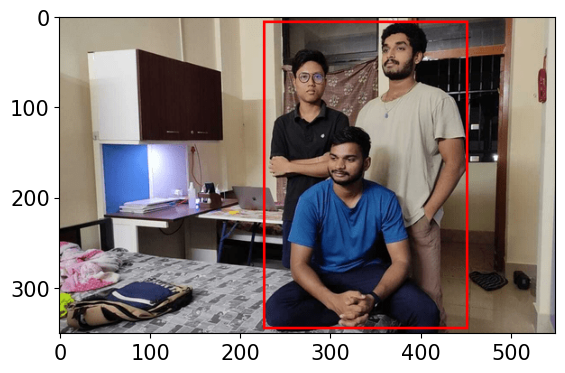

(0.0, 1.0, 0.0, 1.0)

In [94]:
plt.show(full)
plt.axis('on')
# save_path = 'C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/Xen_full.png'
# plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format='png')

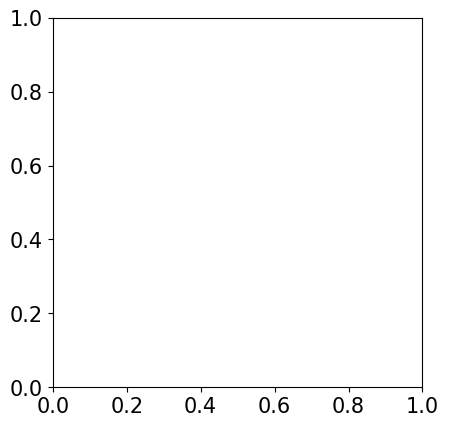

(0.0, 1.0, 0.0, 1.0)

In [85]:
plt.show(new)
plt.axis('on')
# save_path = 'C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/Xen_detected.png'
# plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format='png')


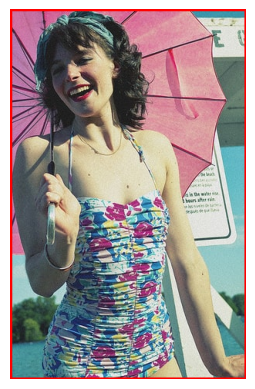

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [31]:
plt.show(new_img)
plt.axis('off')
# save_path = 'C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/Xdetected.png'
# plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format='png')

# <font color='blue'>WATERMARKING start</font>

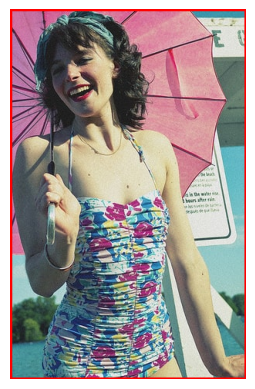

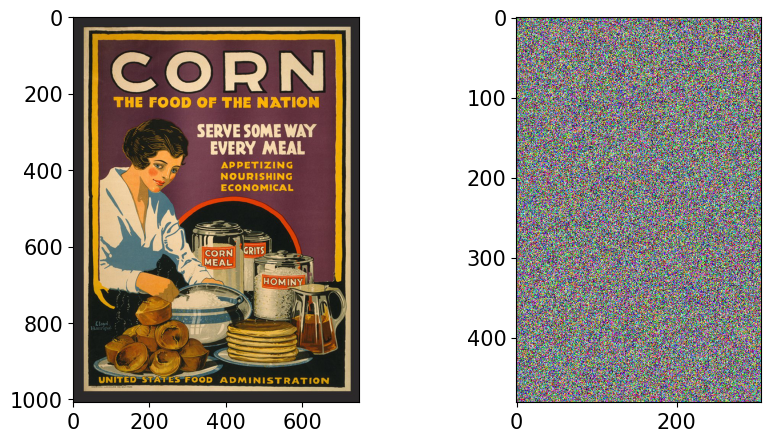

In [144]:
# cover = cv2.resize(cover, (512, 512))
watermark = new
# watermark = cv2.resize(watermark, (256, 256))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cover)
ax[1].imshow(watermark)
plt.show()

# cover.shape, watermark.shape

In [145]:
def embedding(T, CD, Ys=np.random.randint(0, 2**32, 4, dtype=np.uint32), wavelet='dwt', alpha_value=0.86, quantization_bits=4):
    Qs = []
    Y1, Y2, Y3, Y4 = Ys
    LEs = []
    w, h, d = T.shape
    for i in range(d):
        if wavelet == "dwt":
            result = pywt.dwtn(T[:, :, i], wavelet='haar')
            A, H, V, D = result["aa"], result["da"], result["ad"], result["dd"]
        else:
            result = pywt.swt2(T[:, :, i], wavelet='haar', level=1)[0]
            A, (H, V, D) = result[0], result[1]
        A_d, H_d, V_d, D_d = A.copy(), H.copy(), V.copy(), D.copy()
        w, h = A.shape
        n = math.ceil(len(CD[0]) / (w * h))
        z = w * h
        le = len(CD[i])
        LEs.append(le)
        n1, n2, n3, n4 = combination_sum(n)

        #print(n, (n1, n2, n3, n4), le, z, Ys)
        #print("Condition 1:",le < n1*z)
        #print("Condition 2:",n1 * z <= le <= (n1 + n2) * z)
        #print("Condition 3:",(n1 + n2) * z <= le <= (n1 + n2 + n3) * z)
        #print("Condition 4:",(n1 + n2 + n3) * z <= le <= (n1 + n2 + n3 + n4) * z)

        if le < n1 * z:
            C = CD[i][:le]
            D_d = LSB(D, C, Y1, le)
        elif n1 * z <= le <= (n1 + n2) * z:
            C = CD[i][:n1*z]
            D_d = LSB(D, C, Y1, n1*z)
            l = le - n1 * z
            C = CD[i][n1 * z: le]
            V_d = LSB(V, C, Y2, l)
        elif (n1 + n2) * z <= le <= (n1 + n2 + n3) * z:
            C = CD[i][:n1*z]
            D_d = LSB(D, C, Y1, n1*z)
            l = (n1 + n2) * z - n1 * z
            C = CD[i][n1 * z: (n1 + n2) * z]
            V_d = LSB(V, C, Y2, l)
            l = le - (n1 + n2) * z
            C = CD[i][(n1 + n2) * z: le]
            H_d = LSB(H, C, Y3, l)
        elif (n1 + n2 + n3) * z <= le <= (n1 + n2 + n3 + n4) * z:
            C = CD[i][:n1*z]
            D_d = LSB(D, C, Y1, n1 * z)
            l = (n1 + n2) * z - n1 * z
            C = CD[i][n1 * z: (n1 + n2) * z]
            V_d = LSB(V, C, Y2, l)
            l = (n1 + n2 + n3) * z - (n1 + n2) * z
            C = CD[i][(n1 + n2) * z: (n1 + n2 + n3) * z]
            H_d = LSB(H, C, Y3, l)
            l = le - (n1 + n2 + n3) * z
            C = CD[i][(n1 + n2 + n3) * z:le]
            A_d = LSB(A, C, Y4, l)
        if wavelet == 'dwt':
            sq = {"aa": A_d, "da": H_d, "ad": V_d, "dd": D_d}
            Qs.append(pywt.idwtn(sq, wavelet='haar'))
        else:
            Qs.append(pywt.iswt2([A_d, (H_d, V_d, D_d)], wavelet='haar'))
    Qs = np.dstack(Qs)
    
    # QUANTIZATION
    #Qs = (Qs * (2**quantization_bits)).astype(np.uint8) / (2**quantization_bits) 
    # Combine the watermarked image with the original image
    #watermarked_img = Qs * alpha_value + T * (1 - alpha_value)
    
    return Qs, Ys, n, LEs


### alpha values can be adjusted accordingly
#### for bigger images alpha => 1
#### for smaller images alpha => 0.8 <-> 0.9

In [146]:
%%time

watermark_binary = pack_sequence(watermark)
watermark_sequence = "".join(map(str, watermark_binary))
LEN = len(watermark_sequence) // 3
watermark_s = []
watermark_s.extend([watermark_sequence[:LEN], watermark_sequence[LEN:2*LEN], watermark_sequence[2*LEN:]])
watermark_binary = watermark_s
#----------------------------------------------------------------------------------
alpha_value = 0.95
#----------------------------------------------------------------------------------
embedded_img, Ys, n, LEs = embedding(cover, watermark_binary, wavelet='dwt')
embedded_img = embedded_img * alpha_value + cover * (1 - alpha_value) 

plt.imshow(embedded_img.astype(np.uint8))
plt.axis('off')
print("PSNR:", psnr(cover, embedded_img.astype(np.uint8)))
print("SSIM:", SSIM(cover, embedded_img.astype(np.uint8)))

PSNR: 25.224566121475327
SSIM: 0.9358856202824651
CPU times: total: 7 s
Wall time: 7.13 s


# <font color='blue'>WATERMARKING end</font>

# <font color='magenta'>apply noise</font>

In [118]:
probs = [0.01, 0.005, 0.003, 0.001]

# salt pepper

#### below is folder address to save noised images

In [119]:
save_dir = "C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/noised watermark"
os.makedirs(save_dir, exist_ok=True)

In [120]:
def addSaltAndPepperNoise(img,pro):
    # add noise test
    Noise_Img = img.copy()
    rows,cols, d=img.shape
    iNum = math.floor(rows*cols*pro)
    for i in range(iNum):
        x=np.random.randint(0,rows)
        y=np.random.randint(0,cols)
        if np.random.random_sample()<=0.5:
            Noise_Img[x,y]=0# salt
        else:
            Noise_Img[x,y]=255# Pepper   
    return Noise_Img

In [121]:
noise_im = addSaltAndPepperNoise(embedded_img, 0.001)
plt.imshow(np.uint8(noise_im))

In [29]:
plt.figure(figsize=(20, 20))
#----------------------------------------------------------------------------------
for pro in probs:
    noise_im = addSaltAndPepperNoise(embedded_img, pro)
    plt.subplot(1, len(probs), probs.index(pro) + 1)
    plt.imshow(np.uint8(noise_im))
    plt.axis('off')
    save_path = os.path.join(save_dir, f'noised_watermark_p{pro}.png')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format='png')
    plt.clf()
    
plt.show()

#----------------------------------------------------------------------------------

<Figure size 2000x2000 with 0 Axes>

# gaussian noise

In [80]:
def AddGaussianNoise(img,pro):
    #Noise_Img = img / 255.00
    Noise_Img = img.copy()
    rows,cols, d=img.shape
    iNum = math.floor(rows*cols*pro)
    GaussianList = np.random.normal(0, 0.1, (rows,cols, d))
    for m in range(iNum):
        i=np.random.randint(0,rows)
        j=np.random.randint(0,cols)
        k = np.random.randint(0, d)
        Noise_Img[i][j][k] = Noise_Img[i][j][k] + GaussianList[i][j][k]
        if Noise_Img[i][j][k] < 0:
            Noise_Img[i][j][k] = 0
        if Noise_Img[i][j][k] > 1:
            Noise_Img[i][j][k] = 1
    #Noise_Img = skimage.util.img_as_ubyte(Noise_Img)
    return Noise_Img

In [44]:
plt.figure(figsize=(20, 20))
for pro in probs:
    noise_im = AddGaussianNoise(embedded_img, pro)
    plt.subplot(1, len(probs), probs.index(pro) + 1)
    plt.imshow(np.uint8(noise_im))
    plt.axis('off')
    save_path = os.path.join(save_dir, f'gaussian_watermark_p{pro}.png')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format='png')
    plt.clf()
    
plt.show()

<Figure size 2000x2000 with 0 Axes>

# square loss

In [99]:
def addSquareLoss(emb,ratio,position):
    img = emb.copy()
    a,b,c = img.shape # 256 * 256 
    #ratio : 1/64  1/32 1/16 1/8 
    iRow = 0
    iCol = 0
    if ratio == "1/64":
        iRow = 32
        iCol = 32
    elif ratio == "1/32":
        iRow = 32
        iCol = 64
    elif ratio == "1/16":
        iRow = 64
        iCol = 64
    elif ratio == "1/8":
        iRow = 64
        iCol = 128
    elif ratio == "1/4":
        iRow = 128
        iCol = 128
    if position == "U":
        for i in range(iRow):
            for j in range(iCol):
                for k in range(c):
                    img[i][j][k] = 0
    elif position == "C":
        for i in range(iRow):
            for j in range(iCol):
                for k in range(c):
                    img[256-iRow//2+i][256-iCol//2+j][k] = 0
    elif position  == "D":
        for i in range(iRow):
            for j in range(iCol):
                for k in range(c):
                    img[511-iRow+i][511-iCol+j][k] = 0
    
        
    return img

In [100]:
ratios = ["1/64", "1/32", "1/16", "1/8", "1/4"]
positions = ["U", "C", "D"]

In [101]:
output_folder = 'C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/square loss/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [102]:
i = 0   
for ratio in ratios:
    for position in positions:     
        noise_im = addSquareLoss(embedded_img, ratio, position)
        plt.figure(figsize=(10, 10))
        plt.imshow(np.uint8(noise_im))
        plt.axis('off')
        save_path = os.path.join(output_folder, f'{i}.png')
        i = i+1
        plt.savefig(save_path, pad_inches=0, format='png')
        plt.close()

In [151]:
noise_im = addSquareLoss(embedded_img,"1/4","U")
plt.imshow(noise_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.275000000000002..259.75000000000006].


# <font color='magenta'>noise END</font>

# <font color='red'>EXTRACTION start</font>

In [132]:
def extraction(T, Ys, n, LEs, wavelet='dwt'):
    Y1, Y2, Y3, Y4 = Ys
    CD = [""] * 3
    w, h, d = T.shape
    for i in range(d):
        if wavelet == "dwt":
            result = pywt.dwtn(T[:, :, i], wavelet='haar')
            A, H, V, D = result["aa"], result["da"], result["ad"], result["dd"]
        else:
            result = pywt.swt2(T[:, :, i], wavelet='haar', level=1)[0]
            A, (H, V, D) = result[0], result[1]
        w, h = A.shape
        z = w * h
        le = LEs[i]
        n1, n2, n3, n4 = combination_sum(n)

        #print(n, (n1, n2, n3, n4), le, z, Ys)
        #print("Condition 1:",le < n1*z)
        #print("Condition 2:",n1 * z <= le <= (n1 + n2) * z)
        #print("Condition 3:",(n1 + n2) * z <= le <= (n1 + n2 + n3) * z)
        #print("Condition 4:",(n1 + n2 + n3) * z <= le <= (n1 + n2 + n3 + n4) * z)

        if le <= n1 * z:
            C = LSB_invert(D, Y1, le)
            CD[i] += C
        elif n1 * z <= le <= (n1 + n2) * z:
            C = LSB_invert(D, Y1, n1*z)
            CD[i] += C
            l = le - n1 * z
            C = LSB_invert(V, Y2, l)
            CD[i] += C
        elif (n1 + n2) * z <= le <= (n1 + n2 + n3) * z:
            C = LSB_invert(D, Y1, n1*z)
            CD[i] += C
            l = (n1 + n2) * z - n1 * z
            C = LSB_invert(V, Y2, l)
            CD[i] += C
            l = le - (n1 + n2) * z
            C = LSB_invert(H, Y3, l)
            CD[i] += C
        elif (n1 + n2 + n3) * z <= le <= (n1 + n2 + n3 + n4) * z:
            C = LSB_invert(D, Y1, n1 * z)
            CD[i] += C
            l = (n1 + n2) * z - n1 * z
            C = LSB_invert(V, Y2, l)
            CD[i] += C
            l = (n1 + n2 + n3) * z - (n1 + n2) * z
            C = LSB_invert(H, Y3, l)
            CD[i] += C
            l = le - (n1 + n2 + n3) * z
            C = LSB_invert(A, Y4, l)
            CD[i] += C
    return T, CD

In [152]:
%%time
# noise_im = cv2.imread(r"C:\Users\Kaushal Shelke\Desktop\X\Final YOLO\test4\square loss\0.png")
_, data = extraction(noise_im, Ys, n, LEs, wavelet='dwt')
#-----------------------------------------------------------------------------------------
#_, data = extraction(embedded_img, Ys, n, LEs, wavelet='dwt')
#-----------------------------------------------------------------------------------------
watermark_img_ext = unpack_sequence(list(map(int, "".join(data))))
watermark_img_ext=watermark_img_ext.reshape(watermark.shape).astype(np.uint8)
plt.axis('off')
plt.imshow(watermark_img_ext)
save_path = 'C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/extraction.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format='png')

print("PSNR:", psnr(watermark_img_ext, watermark))
print("SSIM:", SSIM(watermark, watermark_img_ext.astype(np.uint8)))
print("nC:", nC(watermark, watermark_img_ext))
print("BER:", BER(watermark, watermark_img_ext, LEs[0]))

PSNR: 24.30937429864828
SSIM: 0.9780007107303424
nC: 0.9944936570184902
BER: 2.319529087911441
CPU times: total: 4.2 s
Wall time: 4.32 s


ext_path = 'C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test3/extracted_secret/1%extN.png'
cv2.imwrite(ext_path, cv2.cvtColor(watermark_img_ext.astype(np.uint8)))

# <font color='red'>EXTRACTION start</font>

# <font color='cyan'>KEY sensitivity</font>


### below keys can be used to decode the xtracted img , "keys" is the orignal key , u can change key1,key2 and add more keys

In [134]:
key1 = list(keys)
key2 = list(keys)
key2[-1] = list(keys[-1])
key2[-1][2] = key2[-1][2] + 1
key2[-1] = tuple(key2[-1])

In [161]:

SCALE=1e8

# def nC(wat, ext):
#     w, h, dim = wat.shape
#     total = 0
#     for d in range(dim):
#         norm_w = np.linalg.norm(wat)
#         norm_e = np.linalg.norm(ext)

#         wi = wat / norm_w
#         ei = ext / norm_e

#         tot = 0
#         for i in range(w):
#             tot += np.sum(wi[i] * ei[i])

#         tot2 = 0
#         for i in range(w):
#             tot2 += np.sum(wi[i] * wi[i])
#         total += tot / tot2
#     return total/3


def nC(wat, ext):
    # Ensure wat and ext are same shape
    if wat.shape != ext.shape:
        # Resize ext to match wat's shape
        ext = cv2.resize(ext, (wat.shape[1], wat.shape[0]))

    w, h, dim = wat.shape
    total = 0

    for d in range(dim):
        norm_w = np.linalg.norm(wat[:, :, d])
        norm_e = np.linalg.norm(ext[:, :, d])

        if norm_w == 0 or norm_e == 0:
            continue

        wi = wat[:, :, d] / norm_w
        ei = ext[:, :, d] / norm_e

        tot = np.sum(wi * ei)
        tot2 = np.sum(wi * wi)

        total += tot / tot2 if tot2 != 0 else 0

    return total / 3


def BER(wat, ext, length):
    w, h, dim = wat.shape
    total = 0
    for d in range(dim):
        tot = 0
        for i in range(w):
            tot += np.sum(np.abs(ext[i, :, d] - wat[i, :, d]))
        total += tot / length
    return total / 3

def SSIM(img, img2):
    w, h, dim = img.shape
    tot = 0
    for d in range(dim):
        tot += ssim(img[:, :, d], img2[:, :, d])
    return tot / 3

def change_bit(x, bit, n=1) -> int:
    sub = ""
    if x < 0:
        sub = "-"
        x *= -1
    binary = format(x, "b")
    binary = list("0" * n + binary)
    binary[-n] = str(bit)
    new = sub + "".join(binary)
    return int(new, 2)

def get_bit(x, n=1):
    if x < 0:
        x *= -1
    binary = format(x, "b")
    binary = "0" * n + binary
    return binary[-n]

def combination_sum(target, y=3):
    combs = list(itertools.combinations_with_replacement(range(target+1), 4))
    results = list(filter(lambda x: sum(x) == target, combs))
    return results[-1][::-1]

def LSB(D, C, Y, Z, scale=SCALE):
    D = D.copy()
    w, h = D.shape
    le = len(C)
    D = np.round(D.flatten()).astype(int)
    len_d = len(D)

    np.random.seed(Y)
    indices = np.random.choice(range(len_d), len_d, replace=False)
    _c = 1
    while Z > 0:
        for j in range(len_d):
            i = indices[j]
            if C[j + len_d * (_c - 1)] == "0":
                D[i] = change_bit(D[i], 0, n=_c)
            else:
                D[i] = change_bit(D[i], 1, n=_c)
            Z -= 1
            if Z == 0:
                break
        _c += 1
    D = D.reshape(w, h)
    return D

def LSB_invert(D, Y, Z, scale=SCALE):
    D = D.copy()
    w, h = D.shape
    D = np.round(D.flatten()).astype(int)
    len_d = len(D)
    C = ""

    np.random.seed(Y)
    indices = np.random.choice(range(len_d), len_d, replace=False)
    _c = 1
    while Z > 0:
        for j in range(len_d):
            i = indices[j]
            C += get_bit(D[i], n=_c)
            Z -= 1
            if Z == 0:
                break
        _c += 1

    return C

# <font color='magenta'>DECODE start</font>

In [135]:
def Img_decode(new,keys,cords) :
#----------------------------------------------------------------------------------                          
    dec_img = Image.fromarray(new)
    dec_img = np.array(dec_img)
    dec_img = dec_img[cords[1]:cords[3], cords[0]:cords[2]]
#----------------------------------------------------------------------------------                      
    start_dec = time.perf_counter()
    decrypted = DoColorDec(new, keys, round=1)
    end_dec = time.perf_counter()
    print("Decryption Time:", (end_dec - start_dec))
    plt.imshow(decrypted)
    #plt.title("this is decrypted")
    
    return decrypted

In [153]:
decrypt_img = Img_decode(watermark_img_ext,keys,cords)
plt.imshow(decrypt_img)
plt.axis('off')
save_path = 'C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/noised decrypted.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format='png')


Decryption Time: 2.3006815999997343


## working on restoration

In [95]:
from huggingface_hub import from_pretrained_keras
from keras.layers import TFSMLayer
import tensorflow as tf
from PIL import Image, ImageEnhance

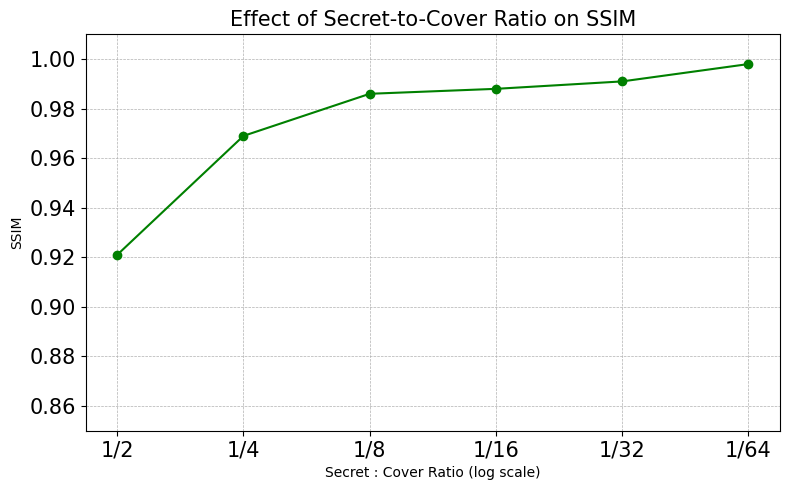

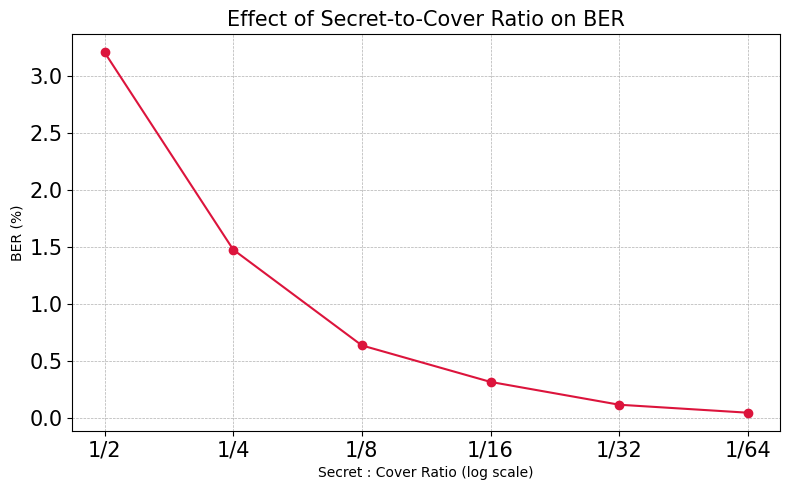

In [101]:
import matplotlib.pyplot as plt

# Secret:Cover ratios and values
ratios = ['1/2', '1/4', '1/8', '1/16', '1/32', '1/64']
x_vals = [1/2, 1/4, 1/8, 1/16, 1/32, 1/64]

# Corresponding SSIM and BER values
ssim_values = [0.921, 0.969, 0.986, 0.988, 0.991, 0.998]
ber_values = [3.21, 1.48, 0.64, 0.32, 0.12, 0.05]

# SSIM Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, ssim_values, marker='o', color='green')
plt.xscale('log', base=2)
plt.gca().invert_xaxis()
plt.title("Effect of Secret-to-Cover Ratio on SSIM")
plt.xlabel("Secret : Cover Ratio (log scale)")
plt.ylabel("SSIM")
plt.xticks(x_vals, ratios)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim(0.85, 1.01)
plt.tight_layout()
plt.show()

# BER Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, ber_values, marker='o', color='crimson')
plt.xscale('log', base=2)
plt.gca().invert_xaxis()
plt.title("Effect of Secret-to-Cover Ratio on BER")
plt.xlabel("Secret : Cover Ratio (log scale)")
plt.ylabel("BER (%)")
plt.xticks(x_vals, ratios)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


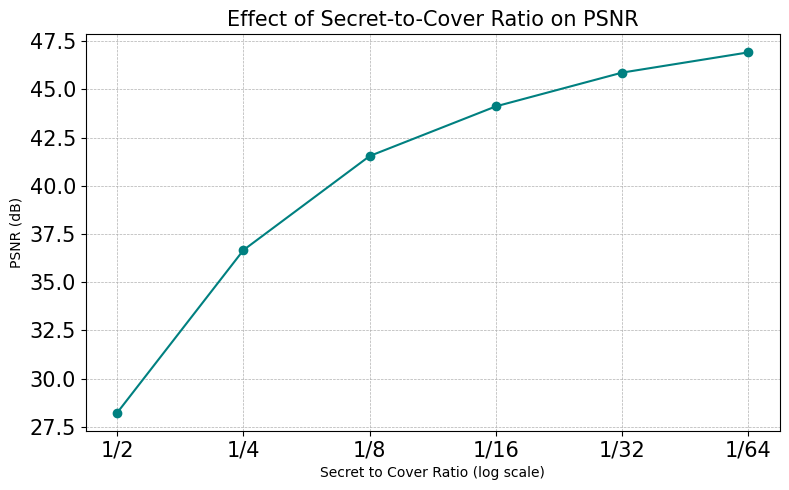

In [99]:
import matplotlib.pyplot as plt

# Ratios and corresponding PSNR values
ratios = ['1/2', '1/4', '1/8', '1/16', '1/32', '1/64']
psnr_values = [28.23, 36.665, 41.544, 44.12, 45.87, 46.92]

# Convert ratio labels to numeric values for X-axis
x_vals = [1/2, 1/4, 1/8, 1/16, 1/32, 1/64]

plt.figure(figsize=(8, 5))
plt.plot(x_vals, psnr_values, marker='o', linestyle='-', color='teal')
plt.xscale('log', base=2)
plt.gca().invert_xaxis()  # So that 1/2 is on the left, 1/64 on the right

plt.title("Effect of Secret-to-Cover Ratio on PSNR")
plt.xlabel("Secret to Cover Ratio (log scale)")
plt.ylabel("PSNR (dB)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.xticks(x_vals, ratios)

plt.tight_layout()
plt.show()


In [97]:
model_path = r"C:\Users\Kaushal Shelke\.cache\huggingface\hub\models--google--maxim-s3-denoising-sidd\snapshots\141a836202bc55ec1a669f85307a560a1b045fb9"
model = TFSMLayer(model_path, call_endpoint="serving_default")

In [204]:
image = cv2.imread("C:\Users\Kaushal Shelke\Desktop\X\Final YOLO\test3\noised decrypted\112dec.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image, (256, 256))

# Normalize and prepare input
input_img = image_resized.astype(np.float32) / 255.0
input_img = np.expand_dims(input_img, axis=0)  # (1, 256, 256, 3)
input_tensor = tf.convert_to_tensor(input_img, dtype=tf.float32)

# Run inference
predictions = model(input_tensor)

KeyError: 0

In [219]:
output_tensor = list(predictions.values())[0]
output_img = tf.clip_by_value(output_tensor[0], 0.0, 1.0).numpy()
orig_h, orig_w = image.shape[:2]
output_img_resized = tf.image.resize(output_img, (orig_h, orig_w), method='bicubic').numpy()
output_uint8 = (output_img_resized * 255).astype(np.uint8)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(output_uint8, cv2.COLOR_RGB2GRAY)

# Compute edge map using Laplacian
edges = cv2.Laplacian(gray, cv2.CV_64F)
edges = np.absolute(edges)
edges = np.uint8(edges)

# Normalize edges and convert to 3 channels
edges_norm = edges / 255.0
edges_mask = cv2.merge([edges_norm] * 3)  # shape: (H, W, 3), values ∈ [0,1]

# Define sharpening kernel
sharpen_kernel = np.array([
    [0, -1,  0],
    [-1, 5.1, -1],
    [0, -1,  0]
])

# Apply sharpening to full image
sharpened_full = cv2.filter2D(output_uint8, -1, sharpen_kernel)

# Blend only edges with original using edge mask
sharpened_edges = output_uint8 * (1 - edges_mask) + sharpened_full * edges_mask
sharpened_edges = np.clip(sharpened_edges, 0, 255).astype(np.uint8)

# Convert to PIL and apply saturation enhancement
img_pil = Image.fromarray(sharpened_edges)
enhancer = ImageEnhance.Color(img_pil)
enhanced_img = enhancer.enhance(1.4)

enhanced_img.save("C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/denoised_upscaled_output.png")


# output_pil = Image.fromarray(output_uint8)
# output_pil.save("C:/Users/Kaushal Shelke/Desktop/X/Final YOLO/test4/denoised_upscaled_output.png")

In [205]:
print(type(predictions))
print(predictions)


<class 'dict'>
{'tf.__operators__.add_367': <tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
array([[[[    0.72031,     0.35731,     0.45775],
         [    0.71015,      0.4204,     0.56144],
         [     0.7002,     0.42505,     0.56995],
         ...,
         [    0.49512,     0.51811,     0.56284],
         [    0.49971,     0.51878,     0.55332],
         [    0.49101,     0.49937,     0.52215]],

        [[    0.72639,     0.37252,     0.47813],
         [     0.7314,       0.479,     0.60344],
         [    0.73491,     0.48481,     0.61563],
         ...,
         [    0.62746,      0.6789,      0.6751],
         [    0.64626,     0.69406,      0.6789],
         [    0.66663,     0.69048,     0.67155]],

        [[    0.72999,     0.38135,     0.49487],
         [    0.73587,     0.48514,      0.6043],
         [    0.73462,     0.49065,     0.61511],
         ...,
         [    0.76389,      0.7675,     0.71512],
         [    0.77016,     0.78009,     0.73015],
    

In [ ]:
# Display
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output_img_resized)
plt.title("Denoised Output (Upscaled)")
plt.axis("off")
plt.show()

In [194]:
resto = cv2.imread(r"C:\Users\Kaushal Shelke\Desktop\X\Final YOLO\test4\noised decrypted_Nero_AI_Image_Denoiser.png")
resto = cv2.cvtColor(resto, cv2.COLOR_BGR2RGB)

# Convert to grayscale to detect edges
gray = cv2.cvtColor(resto, cv2.COLOR_RGB2GRAY)

# Detect edges using Laplacian (or you can use cv2.Canny)
edges = cv2.Laplacian(gray, cv2.CV_64F)
edges = np.absolute(edges)
edges = np.uint8(edges)

# Normalize edge map to [0, 1]
edges_norm = edges / 255.0
edges_mask = cv2.merge([edges_norm, edges_norm, edges_norm])  # match 3 channels

# Define sharpening kernel
sharpen_kernel = np.array([
    [0, -1,  0],
    [-1,  5.9, -1],
    [0, -1,  0]
])

# Apply sharpening to the whole image
sharpened_full = cv2.filter2D(resto, -1, sharpen_kernel)

# Blend only edges with original using edge mask
sharpened_edges = resto * (1 - edges_mask) + sharpened_full * edges_mask
sharpened_edges = np.clip(sharpened_edges, 0, 255).astype(np.uint8)



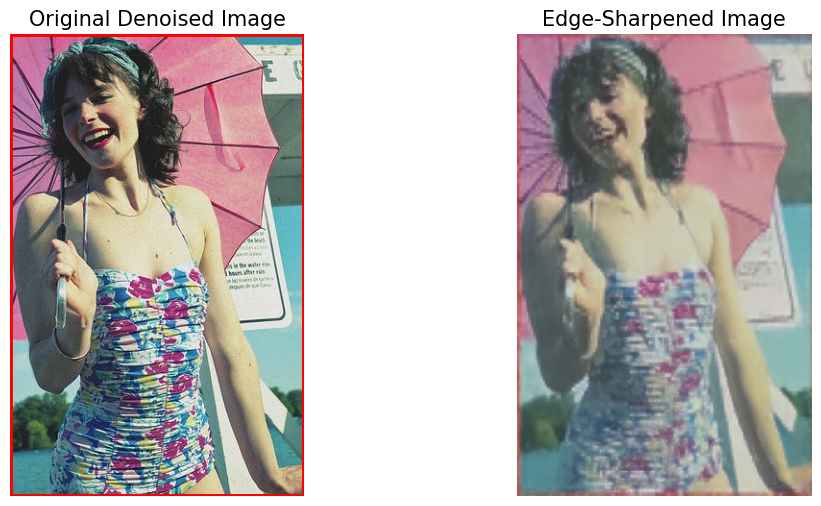

In [196]:
# Show result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(new_img)
plt.title("Original Denoised Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sharpened_edges)
plt.title("Edge-Sharpened Image")
plt.axis("off")
plt.show()

In [225]:
resto = cv2.imread(r"C:\Users\Kaushal Shelke\Desktop\X\Final YOLO\test4\noised decrypted_Nero_AI_Image_Denoiser.png")
resto = cv2.cvtColor(resto, cv2.COLOR_BGR2RGB)

In [226]:
print("nC:", nC(new_img, resto))

nC: 0.9809333902940943


# <font color='magenta'>DECODE end</font>

In [119]:
print(new)
print(new.size)
print(noiseImg)
print(noiseImg.size)
print(decrypt_img)
print(decrypt_img.size)

[[[107 162 207]
  [203 223 166]
  [ 71 106 177]
  ...
  [ 12 211 218]
  [ 60  35  48]
  [140 195  48]]

 [[224 220 138]
  [ 14 160 161]
  [164 153 203]
  ...
  [109 129  65]
  [249 178 241]
  [185 163 143]]

 [[ 16 205  83]
  [ 25  45   3]
  [ 71 195 170]
  ...
  [179  57 131]
  [167 231  99]
  [115  87  88]]

 ...

 [[ 71 247  88]
  [ 66   2 168]
  [181 248  77]
  ...
  [ 34 180 199]
  [ 17 139 187]
  [231 107 123]]

 [[ 13 207 121]
  [179 203 133]
  [ 73 116 236]
  ...
  [ 11 121  94]
  [ 37 137 255]
  [208  11  61]]

 [[191 159  16]
  [198 162  42]
  [ 39   8 186]
  ...
  [ 30 232  37]
  [136 224  97]
  [ 51 128   4]]]
185235


NameError: name 'noiseImg' is not defined

# testing end

## takes img as input n converts to arr then converts it to csv file
ColorDetectionTest function). It returns multiple values which are assigned to variables as follows:
_ (underscore): This is a common convention in Python to indicate that a value is intentionally ignored or not needed.
shape: The shape information of the image after object detection.
enctime: The encryption time for object detection.
dectime: The decryption time for object detection.
coords: A tuple containing the coordinates of detected objects.